In [10]:
from pathlib import Path

import numpy as np
from numba import njit, prange

from matplotlib import pyplot as plt

### Load data

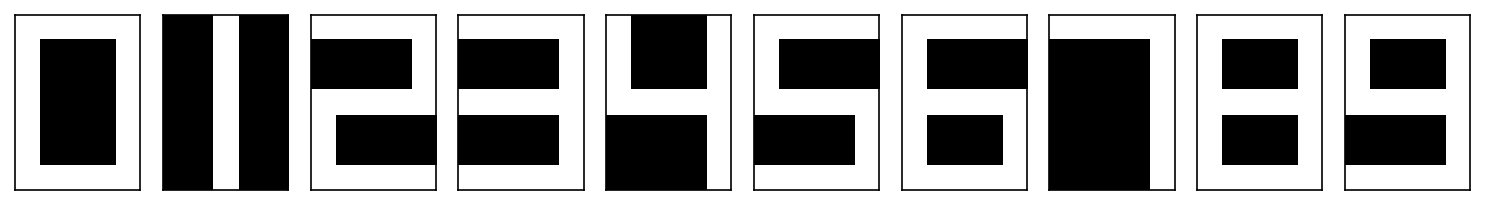

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

data_mtrx = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/numbers_7x5.txt'))
img_size = 35
img_shape = (7, 5)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [12]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [13]:
features = []
labels = []

for i, reference_sample in enumerate(data_mtrx):
    features.append(reference_sample)
    labels.append(one_hot_encoding(10, i))

    for j in range(9):
        noised_sample = reference_sample + np.random.uniform(0.0, 0.25, img_size)
        
        features.append(noised_sample)
        labels.append(one_hot_encoding(10, i))

features = np.array(features)
labels = np.array(labels)

### Split dataset to test and train

In [14]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = np.array(features[idx_test])
y_test = np.array(labels[idx_test])

x_train = np.array(features[idx_train])
y_train = np.array(labels[idx_train])

### Define activation functions

In [15]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> float:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [47]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, V: np.ndarray, c: np.ndarray, W: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    dc = np.zeros(c.shape)

    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    for i in prange(xBatch.shape[0]):
        u = V @ xBatch[i] + c
        h = sigmoid(u)
        y = softmax(W @ h + b)

        dLdh = W.T @ (y - yBatch[i]) * dSigmoid(u)

        dV += np.outer(dLdh, xBatch[i])
        dc += dLdh

        dW += np.outer(y - yBatch[i], h)
        db += y - yBatch[i]

    return (dV, dc, dW, db)


class MultiLayerPeceptron:
    def __init__(self, nIn: int, nH: int, nOut: int) -> None:
        self.nIn = nIn
        self.nH = nH
        self.nOut = nOut

        self.V: np.ndarray = np.random.uniform(-1, 1, (nH, nIn))
        self.c: np.ndarray = np.zeros(nH)

        self.W: np.ndarray = np.random.uniform(-1, 1, (nOut, nH))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x: np.ndarray) -> np.ndarray:
        h = ReLU(self.V @ x + self.c)
        return softmax(self.W @ h + self.b)

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n // batch_size):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n-1)
                batch_idxs = idxs[ibegin:iend]

                dV, dc, dW, db = grads(
                    xTrain[batch_idxs],
                    yTrain[batch_idxs],
                    self.V,
                    self.c,
                    self.W,
                    self.b
                )

                self.V -= lr * dV
                self.c -= lr * dc

                self.W -= lr * dW
                self.b -= lr * db

### Create and train model

In [48]:
nIn = 35
nH = 10
nOut = 10

learning_rate = 1e-2
batch_size = 8
max_epoch = 256

model = MultiLayerPeceptron(nIn, nH, nOut)

print('untrained loss: ', model.loss(x_test, y_test).round(3))

model.train(
    x_train,
    y_train,
    learning_rate,
    batch_size,
    max_epoch
)

print('trained loss: ', model.loss(x_test, y_test).round(3))

true_pos_count = 0
for x, y in zip(x_test, y_test):
    y_pred = model.predict(x)
    true_pos_count += 1 if np.argmax(y) == np.argmax(y_pred) else 0

accuracy = true_pos_count / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss:  0.491
trained loss:  0.003
test set accuracy: 100.0%


### Test model on big number of noised samples

In [49]:
n_samples = 10000
noise_amplitude = 1.0

true_pos_count = 0

for i in range(n_samples):
    j = i % 10
    x = data_mtrx[j] + np.random.uniform(0, noise_amplitude, img_size)
    y_pred = model.predict(x)
    true_pos_count += 1 if j == np.argmax(y_pred) else 0

print(f"accuracy: {round(true_pos_count / n_samples * 100, 2)}% ({true_pos_count} of {n_samples})")

accuracy: 81.63% (8163 of 10000)


### Visualize model predictions

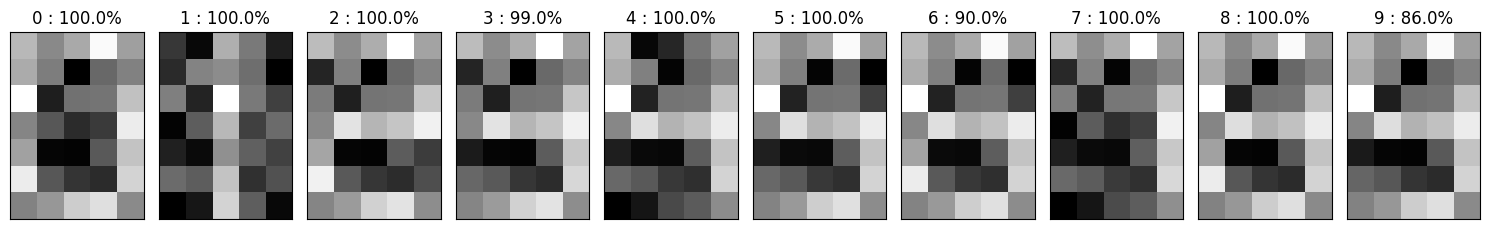

In [50]:
noise_amplitude = 1.0
x_noised = data_mtrx + np.random.uniform(0, noise_amplitude, img_size)

y_pred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    j = np.argmax(y_pred[i])
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    ax.set_title(f"{j} : {(y_pred[i][j] * 100).round()}%")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()